<a href="https://colab.research.google.com/github/greygrease/Project-FoodNet/blob/main/TFDC_Foodnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Check GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-29a1e18d-4d3c-4f9f-3512-9a2ad067fadc)


In [ ]:
# Download helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-07-04 12:50:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-04 12:50:32 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TF Datasets to Download Data

In [ ]:
import tensorflow_datasets as tfds


datasets_list = tfds.list_builders()
print('food101' in datasets_list)

True


In [ ]:
from traitlets.config.application import TRAITLETS_APPLICATION_RAISE_CONFIG_FILE_ERROR
# Load in the data


(train_data, test_data), ds_info = tfds.load(name = 'food101',
                                             split = ['train', 'validation'],
                                             shuffle_files = True,
                                             as_supervised = True,
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompletePEYN2H/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompletePEYN2H/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# Get class names

class_names  = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

## Exploring Food101 Datasets

In [ ]:
# Take one
train_data_sample = train_data.take(1)

In [ ]:
train_data_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our  training sample

for image, label in train_data_sample:
  print(f'''
  Image Shape : {image.shape}
  Image datatype : {image.dtype}
  Target class : {label}
  Target Name : {class_names[label.numpy()]}
  ''')


  Image Shape : (512, 512, 3)
  Image datatype : <dtype: 'uint8'>
  Target class : 30
  Target Name : deviled_eggs
  


In [ ]:
# Min and max values of immage
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot the image

Text(0.5, 1.0, 'deviled_eggs')

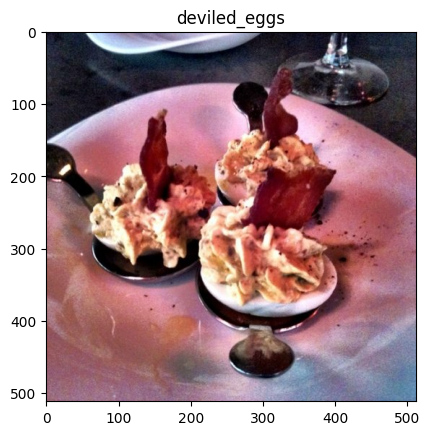

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])

## Create preprocessing functions

In [ ]:
# Make a func for preprocssing image

def preprocess_img(image, label, img_shape = 224):
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

In [ ]:
preprocessed_img = preprocess_img(image, label)[0]

In [ ]:
image[0]

<tf.Tensor: shape=(512, 3), dtype=uint8, numpy=
array([[28, 31, 50],
       [27, 30, 49],
       [21, 23, 44],
       ...,
       [17, 28, 60],
       [20, 30, 65],
       [28, 38, 73]], dtype=uint8)>

In [ ]:
image.shape

TensorShape([512, 512, 3])

In [ ]:
preprocessed_img[0]

<tf.Tensor: shape=(224, 3), dtype=float32, numpy=
array([[ 21.801022 ,  24.801022 ,  43.80102  ],
       [ 17.7551   ,  19.7551   ,  40.755104 ],
       [ 16.16837  ,  18.16837  ,  41.16837  ],
       [ 18.535713 ,  20.535713 ,  43.535713 ],
       [ 15.158162 ,  17.158163 ,  38.311222 ],
       [ 26.994896 ,  29.994896 ,  47.65816  ],
       [ 24.091831 ,  27.091831 ,  44.09183  ],
       [ 22.739801 ,  25.382658 ,  45.096947 ],
       [ 25.94898  ,  30.948978 ,  49.948982 ],
       [ 20.770405 ,  27.198978 ,  42.556118 ],
       [ 22.392841 ,  31.392845 ,  42.892838 ],
       [ 23.831629 ,  36.188774 ,  44.617344 ],
       [ 22.719374 ,  37.719376 ,  43.91325  ],
       [ 18.663265 ,  34.377552 ,  39.632656 ],
       [ 16.979614 ,  33.622475 ,  48.551056 ],
       [ 22.40305  ,  38.40305  ,  54.40305  ],
       [ 23.755108 ,  35.54082  ,  57.54082  ],
       [ 21.57143  ,  31.07143  ,  53.57143  ],
       [ 23.903067 ,  31.903067 ,  54.903065 ],
       [ 25.704084 ,  36.704086 ,  56.

In [ ]:
preprocessed_img.shape

TensorShape([224, 224, 3])

## Batch and prepare datasets

In [ ]:
train_data_ = train_data.map(map_func = preprocess_img,
                              num_parallel_calls = tf.data.AUTOTUNE)
# Shuffle train and turn it into batches
train_data_batch = train_data_.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
test_data_batch = test_data.map(map_func = preprocess_img,
                             num_parallel_calls = tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_data_batch, test_data_batch

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

In [ ]:
# Create tensorboard callback

from helper_functions import create_tensorboard_callback

# Model ckcpt
check_pt_path = 'model_checkpoint/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(check_pt_path,
                                                     monitor = 'val_acc',
                                                     save_best_only = True,
                                                     save_weights_only = True,
                                                     verbose = 0)

## Setup mixed precision

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

## Build a feature extraction model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False


inputs = layers.Input(shape = input_shape, name = 'input_layer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
output = layers.Activation('softmax', dtype = 'float32', name = 'softmax_float32')(x)
model = tf.keras.Model(inputs, output)


model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
for layer in base_model.layers[:10]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">


## Fit the feature extraction model

In [ ]:
history_feature_extraction = model.fit(train_data_batch,
                                       epochs = 3,
                                      steps_per_epoch = len(train_data_batch),
                                      validation_data = test_data_batch,
                                      validation_steps = int(0.15 * len(test_data_batch)),
                                      callbacks = [create_tensorboard_callback(dir_name = 'training_logs',
                                                                                experiment_name = 'effb0'),
                                      model_checkpoint])

Saving TensorBoard log files to: training_logs/effb0/20230704-052623
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7142 - accuracy: 0.5838

2368/2368 [==============================] - 246s 100ms/step - loss: 1.7142 - accuracy: 0.5838 - val_loss: 1.1242 - val_accuracy: 0.6978
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1987 - accuracy: 0.6895

2368/2368 [==============================] - 192s 80ms/step - loss: 1.1987 - accuracy: 0.6895 - val_loss: 1.0301 - val_accuracy: 0.7225
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0534 - accuracy: 0.7240

2368/2368 [==============================] - 190s 79ms/step - loss: 1.0534 - accuracy: 0.7240 - val_loss: 0.9934 - val_accuracy: 0.7214


In [ ]:
# Eval
results_feature_extract = model.evaluate(test_data_batch)

790/790 [==============================] - 57s 72ms/step - loss: 0.9951 - accuracy: 0.7298


## Fine Tuning the Model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False


inputs = layers.Input(shape = input_shape, name = 'input_layer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
output = layers.Activation('softmax', dtype = 'float32', name = 'softmax_float32')(x)
fine_model = tf.keras.Model(inputs, output)

for layer in fine_model.layers:
  layer.trainable = True

fine_model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(0.0001),
              metrics = ['accuracy'])

### Creating callbacks

In [ ]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                  patience = 3)

# Model chpt
checkpoint_path = 'fine_tune_ckpts/'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      monitor = 'val_loss')

# Reduce Lr

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_lr = 1e-7)

In [ ]:
history_fine_tune = fine_model.fit(train_data_batch,
                                      epochs = 100,
                                      steps_per_epoch = len(train_data_batch),
                                      validation_data = test_data_batch,
                                      validation_steps = int(0.15 * len(test_data_batch)),
                                      callbacks = [
                                          create_tensorboard_callback(dir_name = 'training_logs',
                                                                       experiment_name = 'fine_tune_101'),
                                          model_checkpoint,
                                          early_stopping,
                                          reduce_lr
                                      ])

Saving TensorBoard log files to: training_logs/fine_tune_101/20230704-130632
Epoch 1/100
2368/2368 [==============================] - 432s 151ms/step - loss: 1.6281 - accuracy: 0.5879 - val_loss: 0.8935 - val_accuracy: 0.7529 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 359s 150ms/step - loss: 0.8461 - accuracy: 0.7708 - val_loss: 0.7856 - val_accuracy: 0.7820 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 357s 150ms/step - loss: 0.5400 - accuracy: 0.8489 - val_loss: 0.7748 - val_accuracy: 0.7924 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 357s 150ms/step - loss: 0.3166 - accuracy: 0.9064 - val_loss: 0.8668 - val_accuracy: 0.7918 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9428
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 359s 150ms/step - loss: 0.1860 - accur

In [ ]:
fine_model.evalaute(test_data_batch)

In [ ]:
finetune_model.summary()